In [1]:
import torch
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
use_cuda = torch.cuda.is_available()

Sun Feb  1 11:45:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.40                 Driver Version: 576.40         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             27W /  390W |   23768MiB /  24576MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
SEED = 42
WEIGHTED = True

In [3]:
from datasets import *
import pandas as pd
import numpy as np
train = pd.DataFrame(load_dataset("dev_phase2/subtask2/train/eng", split="train"))
train.head()

C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


id  \
0  eng_973938b90b0ff5d87d35a582f83f5c89   
1  eng_07dfd4600426caca6e2c5883fcbea9ea   
2  eng_f14519ff2302b6cd47712073f13bc461   
3  eng_e48b7e7542faafa544ac57b64bc80daf   
4  eng_7c581fb77bce8033aeba3d6dbd6273eb   

                                                text  political  \
0           is defending imperialism in the dnd chat          0   
1  Still playing with this. I am now following Ra...          0   
2  .senate.gov Theres 3 groups out there Republic...          0   
3  "ABC MD, David Anderson, said the additional f...          0   
4  "bad people" I have some conservative values s...          0   

   racial/ethnic  religious  gender/sexual  other  
0              0          0              0      0  
1              0          0              0      0  
2              0          0              0      0  
3              0          0              0      0  
4              0          0              0      0

In [4]:
labels = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
def get_text_and_label(df):
  return df.rename(columns={"text": "text"})[["text"] + labels]
train = get_text_and_label(train)
val = get_text_and_label(train)
test = get_text_and_label(train)
print(f"Dataset size: <{len(train.index)}:{len(val.index)}:{len(test.index)}>")
train.head(10)

Dataset size: <2676:2676:2676>


text  political  \
0           is defending imperialism in the dnd chat          0   
1  Still playing with this. I am now following Ra...          0   
2  .senate.gov Theres 3 groups out there Republic...          0   
3  "ABC MD, David Anderson, said the additional f...          0   
4  "bad people" I have some conservative values s...          0   
5  "Enemy of the people" was a phrase coined and ...          0   
6  "He also voiced support for Elon Musk, Tommy R...          0   
7  "If you disagree with imperialism, youre a sup...          0   
8  "italian" as a national identity is totally ov...          0   
9    "No to ethnic cleansing". QudsDay QudsMainIssue          0   

   racial/ethnic  religious  gender/sexual  other  
0              0          0              0      0  
1              0          0              0      0  
2              0          0              0      0  
3              0          0              0      0  
4              0          0              0      0  
5              0          0              0      0  
6              0          0              0      0  
7              0          0              0      0  
8              0          0              0      0  
9              0          0              0      0

In [5]:
def generate_multilabel_df(df):
  df["labels"] = np.empty((len(df), len(labels))).tolist()
  for index, row in df.iterrows():
    row_labels = [row[label] for label in labels]
    for i in range(len(labels)):
      df.loc[index, "labels"][i] = row_labels[i]
  return df[["text", "labels"]]
train = generate_multilabel_df(train)
val = generate_multilabel_df(val)
test = generate_multilabel_df(test)
train.head(10)

text           labels
0           is defending imperialism in the dnd chat  [0, 0, 0, 0, 0]
1  Still playing with this. I am now following Ra...  [0, 0, 0, 0, 0]
2  .senate.gov Theres 3 groups out there Republic...  [0, 0, 0, 0, 0]
3  "ABC MD, David Anderson, said the additional f...  [0, 0, 0, 0, 0]
4  "bad people" I have some conservative values s...  [0, 0, 0, 0, 0]
5  "Enemy of the people" was a phrase coined and ...  [0, 0, 0, 0, 0]
6  "He also voiced support for Elon Musk, Tommy R...  [0, 0, 0, 0, 0]
7  "If you disagree with imperialism, youre a sup...  [0, 0, 0, 0, 0]
8  "italian" as a national identity is totally ov...  [0, 0, 0, 0, 0]
9    "No to ethnic cleansing". QudsDay QudsMainIssue  [0, 0, 0, 0, 0]

In [6]:
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs
model_args = MultiLabelClassificationArgs(
    overwrite_output_dir= True,
    eval_batch_size=8,
    num_train_epochs=5,
    learning_rate = 4e-05,
    optimizer="AdamW",
    manual_seed=SEED,
    use_early_stopping=True,
)

In [7]:
models = {
    "mbert-cased": MultiLabelClassificationModel("bert", 'models--google-bert--bert-base-multilingual-cased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "mbert-uncased": MultiLabelClassificationModel("bert", 'models--google-bert--bert-base-multilingual-uncased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "roberta": MultiLabelClassificationModel("roberta", 'models--FacebookAI--roberta-base', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "beto-cased": MultiLabelClassificationModel("bert", 'models--dccuchile--bert-base-spanish-wwm-cased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "beto-uncased": MultiLabelClassificationModel("bert", 'models--dccuchile--bert-base-spanish-wwm-uncased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "distilbert-multi": MultiLabelClassificationModel("distilbert", 'models--distilbert--distilbert-base-multilingual-cased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
}

Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at models--google-bert--bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at models--google-bert--bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at models--FacebookAI--roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'roberta.pooler.den

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def root_mean_squared_error(y_true, y_pred):    
    return sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
for model_name, model in models.items():
  model.train_model(train, loss_fct=root_mean_squared_error)

6it [00:04,  1.34it/s]                                                                                                                                                                                                                    
Epochs 5/5. Running Loss:    0.0250:  53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                          | 178/335 [00:12<00:10, 15.00it/s]

Epochs 4/5. Running Loss:    0.1299:  19%|█████████████████████████████▍                                                                                                                                 | 62/335 [00:20<01:25,  3.20it/s]

Epochs 1/5. Running Loss:    0.0987:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 252/335 [04:24<01:28,  1.06s/it]

Epoch 5 of 5: 100%|██████████████████████████████████████

In [10]:
import collections
from itertools import combinations
models_names = list(models.keys())
ensembles_list = list()
for i in range(1, len(models_names) + 1):
    ensembles_list += list(combinations(models_names, i))
ensembles_list = [list(ensemble) for ensemble in ensembles_list]
ensembles = {}
for i in range(len(ensembles_list)):
  ensembles["ensemble{:02d}".format(i)] = {}
  ensembles["ensemble{:02d}".format(i)]["models"] = ensembles_list[i]
  ensembles["ensemble{:02d}".format(i)]["metrics"] = {}
ensembles

{'ensemble00': {'models': ['mbert-cased'], 'metrics': {}},
 'ensemble01': {'models': ['mbert-uncased'], 'metrics': {}},
 'ensemble02': {'models': ['roberta'], 'metrics': {}},
 'ensemble03': {'models': ['beto-cased'], 'metrics': {}},
 'ensemble04': {'models': ['beto-uncased'], 'metrics': {}},
 'ensemble05': {'models': ['distilbert-multi'], 'metrics': {}},
 'ensemble06': {'models': ['mbert-cased', 'mbert-uncased'], 'metrics': {}},
 'ensemble07': {'models': ['mbert-cased', 'roberta'], 'metrics': {}},
 'ensemble08': {'models': ['mbert-cased', 'beto-cased'], 'metrics': {}},
 'ensemble09': {'models': ['mbert-cased', 'beto-uncased'], 'metrics': {}},
 'ensemble10': {'models': ['mbert-cased', 'distilbert-multi'], 'metrics': {}},
 'ensemble11': {'models': ['mbert-uncased', 'roberta'], 'metrics': {}},
 'ensemble12': {'models': ['mbert-uncased', 'beto-cased'], 'metrics': {}},
 'ensemble13': {'models': ['mbert-uncased', 'beto-uncased'], 'metrics': {}},
 'ensemble14': {'models': ['mbert-uncased', 'd

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
def compute_metrics(y_true, y_pred):
  macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
  acc = accuracy_score(y_true, y_pred)
  weighted_f1 = f1_score(y_true, y_pred, average='weighted')  
  return {      
    'accuracy': round(acc, 5),      
    'macro_f1': round(macro_f1, 5),      
    'macro_precision': round(macro_precision, 5),      
    'macro_recall': round(macro_recall, 5),      
    'weighted_f1': round(weighted_f1, 5)  
  }
model_evaluation = {}
for model_name in models:
  model_evaluation[model_name] = {}  
  result, model_outputs, wrong_predictions = models[model_name].eval_model(val, metric=root_mean_squared_error)
  model_evaluation[model_name]["result"] = result                                                                   
  model_evaluation[model_name]["val_model_outputs"] = model_outputs                                                
  model_evaluation[model_name]["val_predictions"] = list ()  
  for output in model_outputs:
    model_evaluation[model_name]["val_predictions"].append([0 if lab_output < 0.5 else 1 for lab_output in output]) 
  model_evaluation[model_name]["val_wrong_predictions"] = wrong_predictions                                          
  model_evaluation[model_name]["metrics"] = compute_metrics(val.get("labels").tolist(), model_evaluation[model_name].get("val_predictions"))  
  print(f"{model_name}\t", model_evaluation[model_name].get("metrics"))

6it [00:04,  1.48it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:03<00:00, 88.40it/s]


mbert-cased	 {'accuracy': 0.91704, 'macro_f1': 0.71218, 'macro_precision': 0.80026, 'macro_recall': 0.66821, 'weighted_f1': 0.89446}


6it [00:03,  1.70it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:03<00:00, 90.66it/s]


mbert-uncased	 {'accuracy': 0.90247, 'macro_f1': 0.68235, 'macro_precision': 0.88431, 'macro_recall': 0.62333, 'weighted_f1': 0.86854}


6it [00:03,  1.76it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:03<00:00, 91.06it/s]


roberta	 {'accuracy': 0.89873, 'macro_f1': 0.64166, 'macro_precision': 0.79444, 'macro_recall': 0.61004, 'weighted_f1': 0.86269}


6it [00:03,  1.81it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:03<00:00, 88.49it/s]


beto-cased	 {'accuracy': 0.95478, 'macro_f1': 0.88885, 'macro_precision': 0.92753, 'macro_recall': 0.85848, 'weighted_f1': 0.95085}


6it [00:03,  1.78it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:03<00:00, 89.14it/s]


beto-uncased	 {'accuracy': 0.91442, 'macro_f1': 0.70449, 'macro_precision': 0.82342, 'macro_recall': 0.64536, 'weighted_f1': 0.88853}


6it [00:03,  1.71it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:02<00:00, 156.16it/s]


distilbert-multi	 {'accuracy': 0.94058, 'macro_f1': 0.82832, 'macro_precision': 0.91112, 'macro_recall': 0.77329, 'weighted_f1': 0.93167}


In [12]:
from sklearn.preprocessing import normalize
def vote(predictions, weighted=False, weights=None):
  votes = list()  
  for i in range(len(labels)):    
    curr_label_preds = [preds[i] for preds in predictions]    
    voting = sum(curr_label_preds * weights) if weighted else sum(curr_label_preds)/len(curr_label_preds)
    votes.append(0 if voting < 0.5 else 1)  
  return votes
ensemble_evaluation = {}
def predict_ensemble(ensemble_name, dataset_name, dataset, weighted=False):
  ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"] = list()  
  for i in range(len(dataset.index)):
    predictions = list()
    ensemble_models = ensembles[ensemble_name].get("models")      
    for model_name in ensemble_models:
      curr_model_outputs = model_evaluation[model_name].get(f"{dataset_name}_model_outputs")
      predictions.append(curr_model_outputs[i])
    weights = list()    
    if weighted:      
      f1_scores_list = [model_evaluation[model_name]["metrics"].get("weighted_f1")                        
                        for model_name in ensembles[ensemble_name].get("models")]
      weights = normalize([f1_scores_list], norm="l1")[0]
    ensemble_pred = vote(predictions, weighted, weights)
    ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"].append(ensemble_pred)
for ensemble_name in ensembles:
  ensemble_evaluation[ensemble_name] = {}
  ensemble_evaluation[ensemble_name]["val_predictions"] = list()
  predict_ensemble(ensemble_name, "val", val, weighted=WEIGHTED)
  ensembles[ensemble_name]["metrics"] = compute_metrics(val.get("labels").tolist(), ensemble_evaluation[ensemble_name].get("val_predictions"))  
  print(f"{ensemble_name}\t", ensembles[ensemble_name].get("metrics"))

ensemble00	 {'accuracy': 0.91704, 'macro_f1': 0.71218, 'macro_precision': 0.80026, 'macro_recall': 0.66821, 'weighted_f1': 0.89446}
ensemble01	 {'accuracy': 0.90247, 'macro_f1': 0.68235, 'macro_precision': 0.88431, 'macro_recall': 0.62333, 'weighted_f1': 0.86854}
ensemble02	 {'accuracy': 0.89873, 'macro_f1': 0.64166, 'macro_precision': 0.79444, 'macro_recall': 0.61004, 'weighted_f1': 0.86269}
ensemble03	 {'accuracy': 0.95478, 'macro_f1': 0.88885, 'macro_precision': 0.92753, 'macro_recall': 0.85848, 'weighted_f1': 0.95085}
ensemble04	 {'accuracy': 0.91442, 'macro_f1': 0.70449, 'macro_precision': 0.82342, 'macro_recall': 0.64536, 'weighted_f1': 0.88853}
ensemble05	 {'accuracy': 0.94058, 'macro_f1': 0.82832, 'macro_precision': 0.91112, 'macro_recall': 0.77329, 'weighted_f1': 0.93167}
ensemble06	 {'accuracy': 0.92078, 'macro_f1': 0.72326, 'macro_precision': 0.9328, 'macro_recall': 0.64643, 'weighted_f1': 0.89546}
ensemble07	 {'accuracy': 0.91442, 'macro_f1': 0.66548, 'macro_precision': 0.8

In [13]:
f1_scores = {ensemble_name: ensembles[ensemble_name]["metrics"].get("weighted_f1") for ensemble_name in ensemble_evaluation}
best_ensemble_name = max(f1_scores, key=f1_scores.get)
best_ensemble = {"name": best_ensemble_name,                 
"models": ensembles[best_ensemble_name].get("models"),                 
"metrics": ensembles[best_ensemble_name].get("metrics")                 
}
best_ensemble

{'name': 'ensemble19',
 'models': ['beto-cased', 'distilbert-multi'],
 'metrics': {'accuracy': 0.95665,
  'macro_f1': 0.88668,
  'macro_precision': 0.95511,
  'macro_recall': 0.83622,
  'weighted_f1': 0.95303}}

In [14]:
for model_name in best_ensemble.get("models"):
  model_predictions, model_raw_outputs = models.get(model_name).predict(test["text"].tolist())
  model_evaluation[model_name]["test_model_outputs"] = model_raw_outputs
  model_evaluation[model_name]["test_predictions"] = list ()  
  for output in model_raw_outputs:
    model_evaluation[model_name]["test_predictions"].append([0 if lab_output < 0.5 else 1 for lab_output in output])
predict_ensemble(best_ensemble.get("name"), "test", test, weighted=WEIGHTED)

6it [00:03,  1.73it/s]                                                                                                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:03<00:00, 86.62it/s]
6it [00:03,  1.77it/s]                                                                                                                                                                                                                    
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 335/335 [00:02<00:00, 155.01it/s]


In [15]:
test["predicted_labels"] = ensemble_evaluation[best_ensemble.get("name")].get("test_predictions")
test.head(10)

text           labels  \
0           is defending imperialism in the dnd chat  [0, 0, 0, 0, 0]   
1  Still playing with this. I am now following Ra...  [0, 0, 0, 0, 0]   
2  .senate.gov Theres 3 groups out there Republic...  [0, 0, 0, 0, 0]   
3  "ABC MD, David Anderson, said the additional f...  [0, 0, 0, 0, 0]   
4  "bad people" I have some conservative values s...  [0, 0, 0, 0, 0]   
5  "Enemy of the people" was a phrase coined and ...  [0, 0, 0, 0, 0]   
6  "He also voiced support for Elon Musk, Tommy R...  [0, 0, 0, 0, 0]   
7  "If you disagree with imperialism, youre a sup...  [0, 0, 0, 0, 0]   
8  "italian" as a national identity is totally ov...  [0, 0, 0, 0, 0]   
9    "No to ethnic cleansing". QudsDay QudsMainIssue  [0, 0, 0, 0, 0]   

  predicted_labels  
0  [0, 0, 0, 0, 0]  
1  [0, 0, 0, 0, 0]  
2  [0, 0, 0, 0, 0]  
3  [0, 0, 0, 0, 0]  
4  [0, 0, 0, 0, 0]  
5  [0, 0, 0, 0, 0]  
6  [0, 0, 0, 0, 0]  
7  [0, 0, 0, 0, 0]  
8  [0, 0, 0, 0, 0]  
9  [0, 0, 0, 0, 0]

In [16]:
from sklearn.metrics import classification_report
cr = classification_report(y_true=test["labels"].tolist(), y_pred=test["predicted_labels"].tolist(), target_names=labels)
print(cr)

               precision    recall  f1-score   support

    political       0.99      0.99      0.99       996
racial/ethnic       0.94      0.96      0.95       264
    religious       0.95      0.86      0.90       106
gender/sexual       1.00      0.69      0.81        67
        other       0.89      0.69      0.78       121

    micro avg       0.97      0.94      0.96      1554
    macro avg       0.96      0.84      0.89      1554
 weighted avg       0.97      0.94      0.95      1554
  samples avg       0.37      0.36      0.36      1554



C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a: [[1671    9]
 [  12  984]]
a: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0.

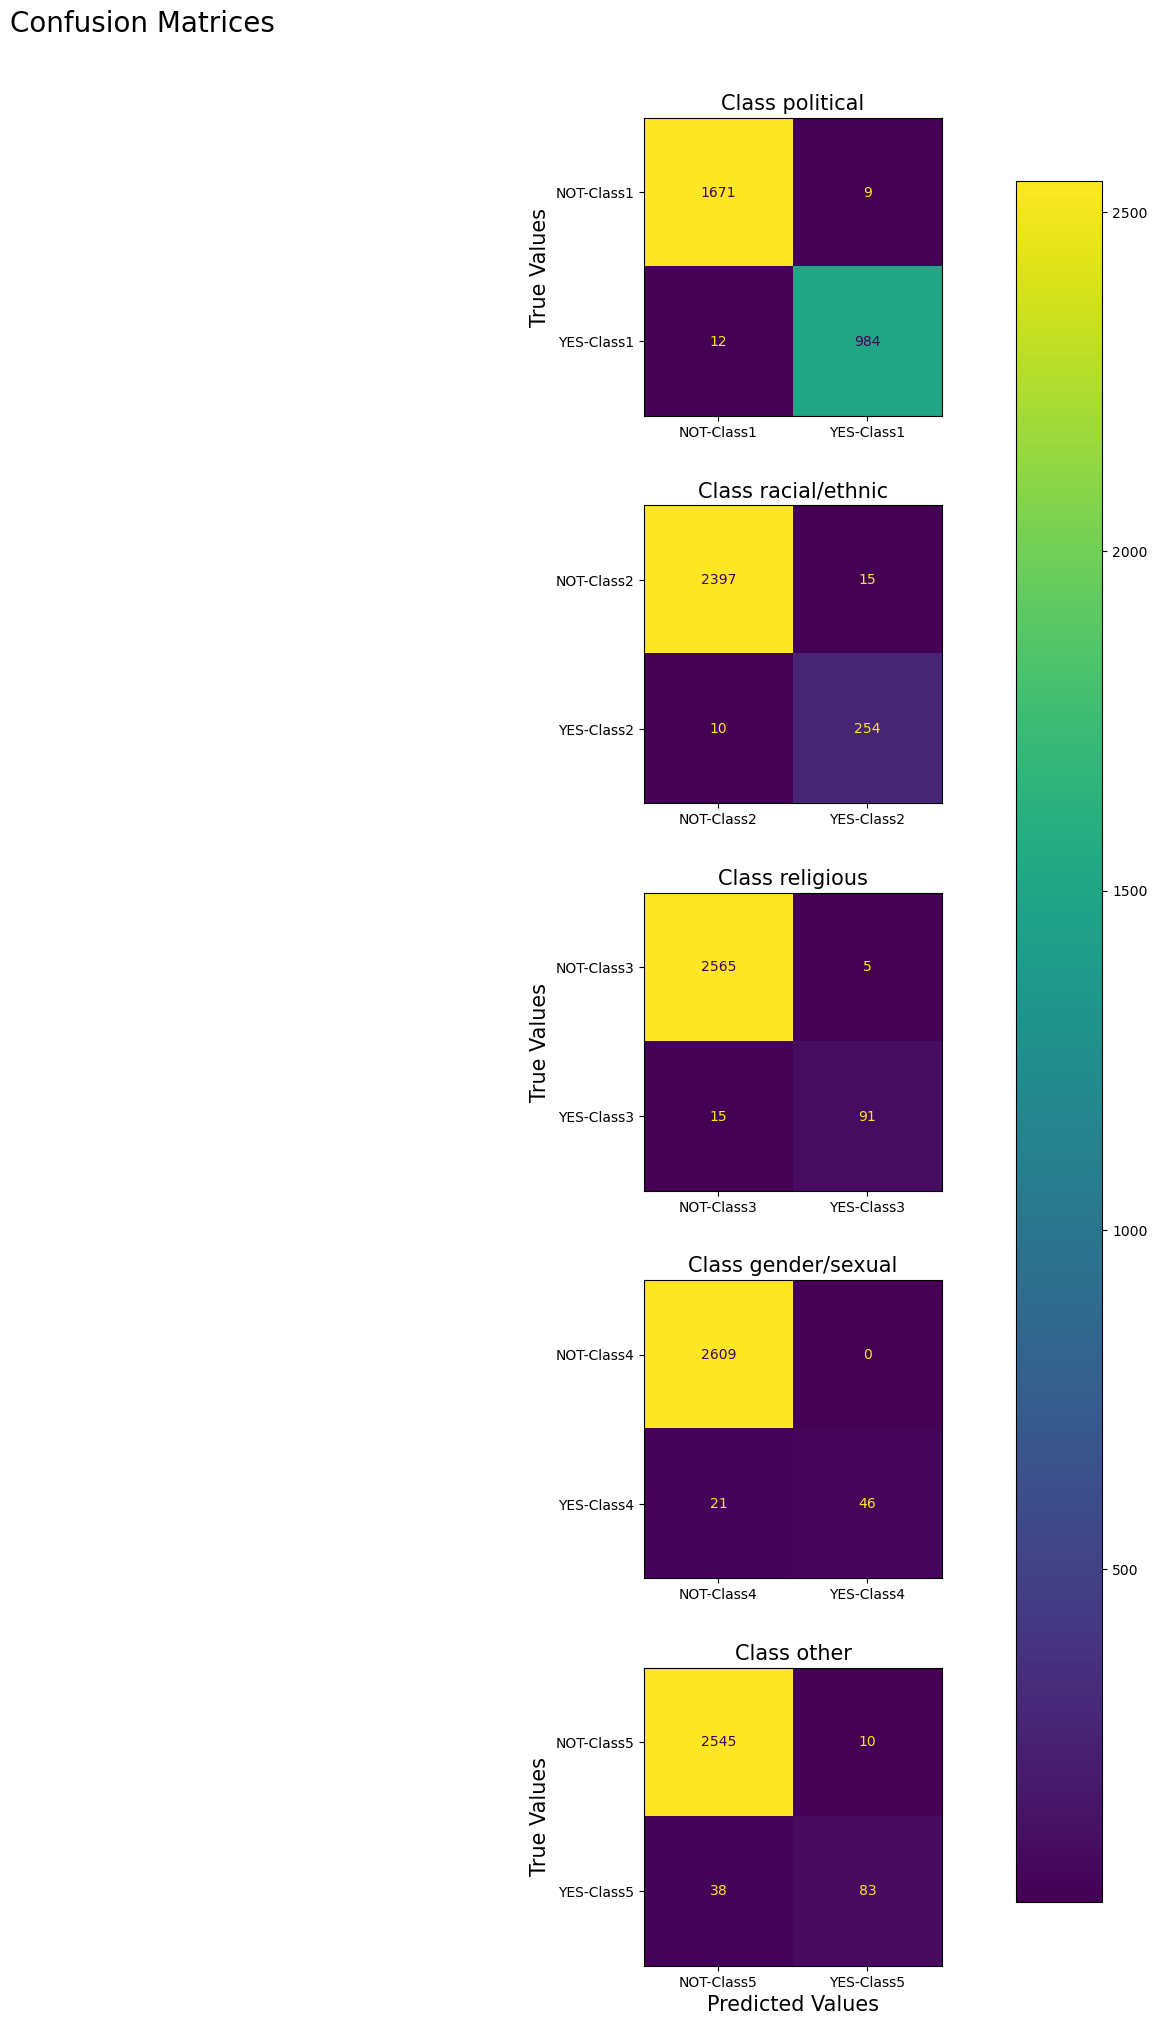

In [18]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1, figsize=(24, 24))
axes = axes.ravel()
for i in range(len(labels)):
  y_true = [label[i] for label in test["labels"].tolist()]
  y_pred = [label[i] for label in test["predicted_labels"].tolist()]
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=[f"NOT-Class{i+1}", f"YES-Class{i+1}"])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title("Class {}".format(labels[i]), fontsize=15)  
  if i<4:
    disp.ax_.set_xlabel('')  
  else:
    disp.ax_.set_xlabel('Predicted Values', fontsize=15)  
  if i%2!=0:
    disp.ax_.set_ylabel('')  
  else:
    disp.ax_.set_ylabel('True Values', fontsize=15)
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.25, hspace=0.3)
fig.colorbar(disp.im_, ax=axes, fraction=0.04625, pad=0.04)
plt.suptitle("Confusion Matrices", fontsize=20, y=0.925)
plt.show()

C:\Users\8888\AppData\Local\Temp\ipykernel_53208\4184596369.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
C:\Users\8888\AppData\Local\Temp\ipykernel_53208\4184596369.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve


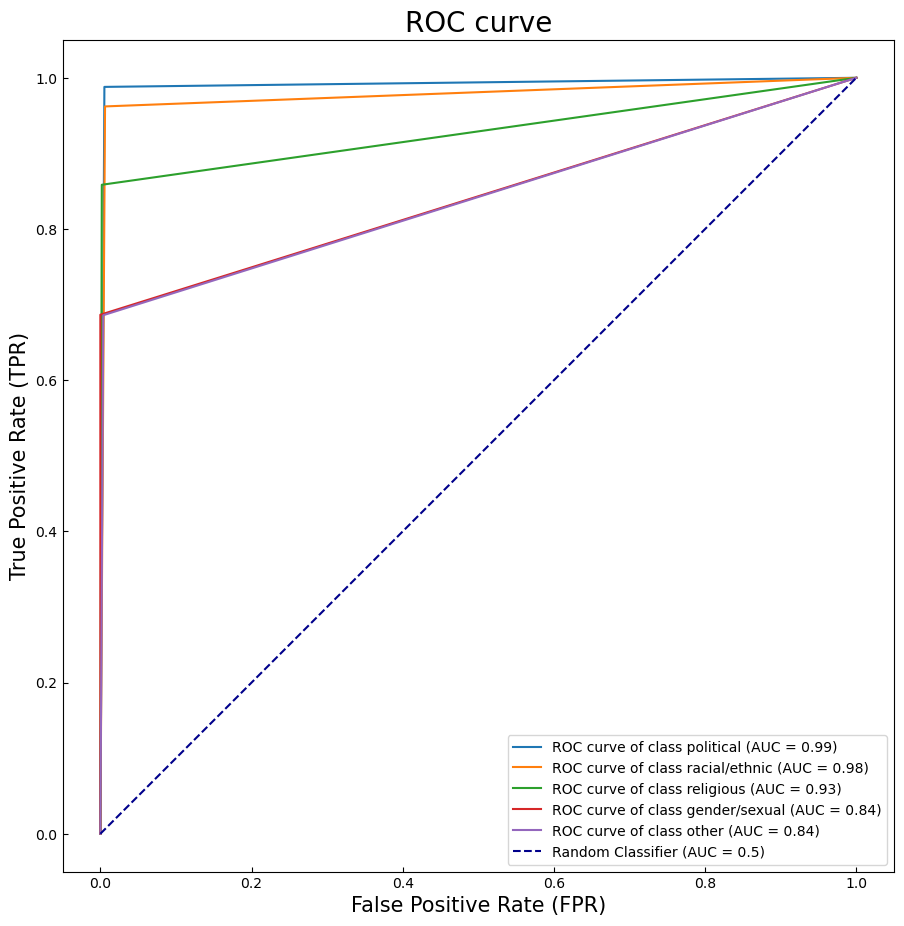

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig = plt.figure(figsize = (10.8, 10.8))
for i in range(len(labels)):
  y_true = [label[i] for label in test["labels"].tolist()]
  y_pred = [label[i] for label in test["predicted_labels"].tolist()]
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  plt.plot(fpr, tpr, label="ROC curve of class {} (AUC = {:0.2f})".format(labels[i], auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
plt.axis("square")
plt.xlabel("False Positive Rate (FPR)", fontsize = 15)
plt.ylabel("True Positive Rate (TPR)", fontsize = 15)
plt.title("ROC curve", fontsize = 20)
plt.tick_params(axis = "y",direction = "in")
plt.tick_params(axis = "x",direction = "in")
plt.legend()
plt.show()